In [1]:
import os
from pathlib import Path
import glob
import cv2
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops
import pickle as pk
import numpy as np
from matplotlib import pyplot as plt

import mbb

In [11]:
#test images dataset processing
image_path = '/home/martin/container/autofs/data/hail/hail_20210620_r1/odm_orthophoto/tiles/cvat/test/'
centroid_path = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/centroid/test/'

if not os.path.exists(centroid_path):
    os.makedirs(centroid_path)
        
all_files = glob.glob(image_path+'*.png')
all_files.sort()

pixel_gsd = 1.5 #pixel ground sample distance in mm

inital_threshold = 0.7 #lightness threshold to use for masking
localmax_mindist = 2 #minimum distance in pixel units between hail centroids
min_area_mm = 3.14*(3**2) #minimum area of hailstone in pixels
min_area = int(min_area_mm/pixel_gsd**2) #minimum area in mm
print(min_area)

12


In [12]:
hail_major = []
hail_minor = []

for file in all_files:
    #transform into hsv colorspace
    stem = Path(file).stem
    
    img_data = cv2.imread(file)
    img_data_hls = cv2.cvtColor(img_data, cv2.COLOR_BGR2HLS)

    l_data = img_data_hls[:,:,1]/255
    #apply inital threshold
    l_mask = l_data > inital_threshold
    #compute distance transform to find centroids
    l_mask_dist = ndimage.distance_transform_edt(l_mask)
    localMax = peak_local_max(l_mask_dist, indices=False, min_distance=localmax_mindist,
        labels=l_mask)

    #run watershed
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-l_mask_dist, markers, mask=l_mask,watershed_line=True)

    #remove small regions
    region_prop_list = regionprops(labels)
    #build centroid list
    hail_centroid_x = []
    hail_centroid_y = []

    for region_prop in region_prop_list:
        if region_prop.area > min_area:
            label_centroid = region_prop.centroid
            hail_centroid_x.append(label_centroid[1])
            hail_centroid_y.append(label_centroid[0])

            hail_pts_i, hail_pts_j = np.where(labels == region_prop.label)
            try:
                bounding_box = mbb.MinimumBoundingBox(list(zip(hail_pts_i,hail_pts_j)))

                len_parallel = bounding_box.length_parallel
                len_orthogonal = bounding_box.length_orthogonal

                #work out maj/min axis length
                if len_parallel>len_orthogonal:
                    maj_axis_len, min_axis_len = len_parallel, len_orthogonal
                else:
                    maj_axis_len, min_axis_len = len_orthogonal, len_parallel

                hail_major.append(maj_axis_len*pixel_gsd)
                hail_minor.append(min_axis_len*pixel_gsd)
            except:
                continue

    hail_centroid_idx = list(range(len(hail_centroid_x)))
    np.savez(centroid_path+stem+'.npz',hail_cx=hail_centroid_x,hail_cy=hail_centroid_y, hail_idx=hail_centroid_idx)

In [5]:
hd_lai = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_lai/hail_sizes/hail_dict.pkl'
hd_mon = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_mon/hail_sizes/hail_dict.pkl'
hd_wod = '/home/martin/container/hail/detectron2/products/annotation/test/hail_20210620_r1_wod/hail_sizes/hail_dict.pkl'
hd_model = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/hail_20210620_r1/test/hail_sizes_ml/hail_dict.pkl'

with open(hd_model,'rb') as f:
    hd_dict = pk.load(f)

with open(hd_lai,'rb') as f:
    hd_dict_lai = pk.load(f)
    
with open(hd_mon,'rb') as f:
    hd_dict_mon = pk.load(f)
    
with open(hd_wod,'rb') as f:
    hd_dict_wod = pk.load(f)

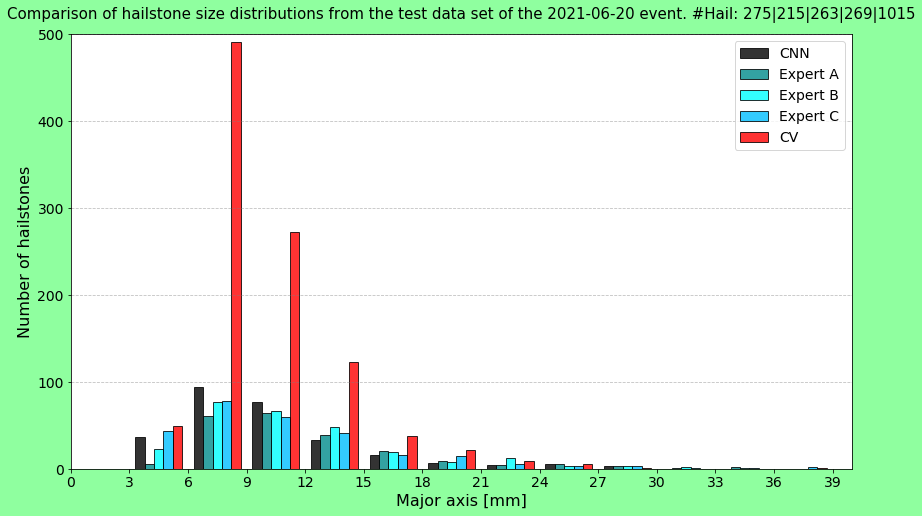

In [14]:
plot_dir = '/home/martin/container/autofs/data/hail/hail_20210620_r1/products/cv/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
        
#Plot real distribution of test dataset man vs machine
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


n_hail_ml = np.size(hd_dict['major_ma'])
n_hail_cv = np.size(hail_major)
n_hail_lai = np.size(hd_dict_lai['major_ma'])
n_hail_mon = np.size(hd_dict_mon['major_ma'])
n_hail_wod = np.size(hd_dict_wod['major_ma'])

fig, ax = plt.subplots(figsize=[14,8])
fig.patch.set_facecolor('xkcd:mint green')
numBins = 14
bins = ax.hist([hd_dict['major_ma'],hd_dict_lai['major_ma'], hd_dict_mon['major_ma'], hd_dict_wod['major_ma'], hail_major],numBins,range=[3,45],color=['black','darkcyan','cyan','deepskyblue','red'],alpha=0.8, edgecolor='black',label=['CNN','Expert A','Expert B','Expert C', 'CV'])

#ax.hist(data,numBins,range=[2.5,42.5],color='blue',alpha=0.8, edgecolor='black')
plt.title('Comparison of hailstone size distributions from the test data set of the 2021-06-20 event. #Hail: '+str(n_hail_ml)+'|'+str(n_hail_lai)+'|'+str(n_hail_mon)+'|'+str(n_hail_wod)+'|'+str(n_hail_cv),fontsize=15,pad=15)
plt.ylim([0,500])
plt.xlim([0,40])
plt.grid(axis='y',color='grey',linestyle='--',alpha=0.5)
plt.xticks(np.linspace(0,39,14))
plt.ylabel('Number of hailstones')
plt.xlabel('Major axis [mm]')
plt.legend(loc='upper right')
plt.savefig(plot_dir+'Comparison_test_distributions_major_cv3.png',dpi=300,bbox_inches='tight',facecolor='xkcd:mint green')
plt.show()

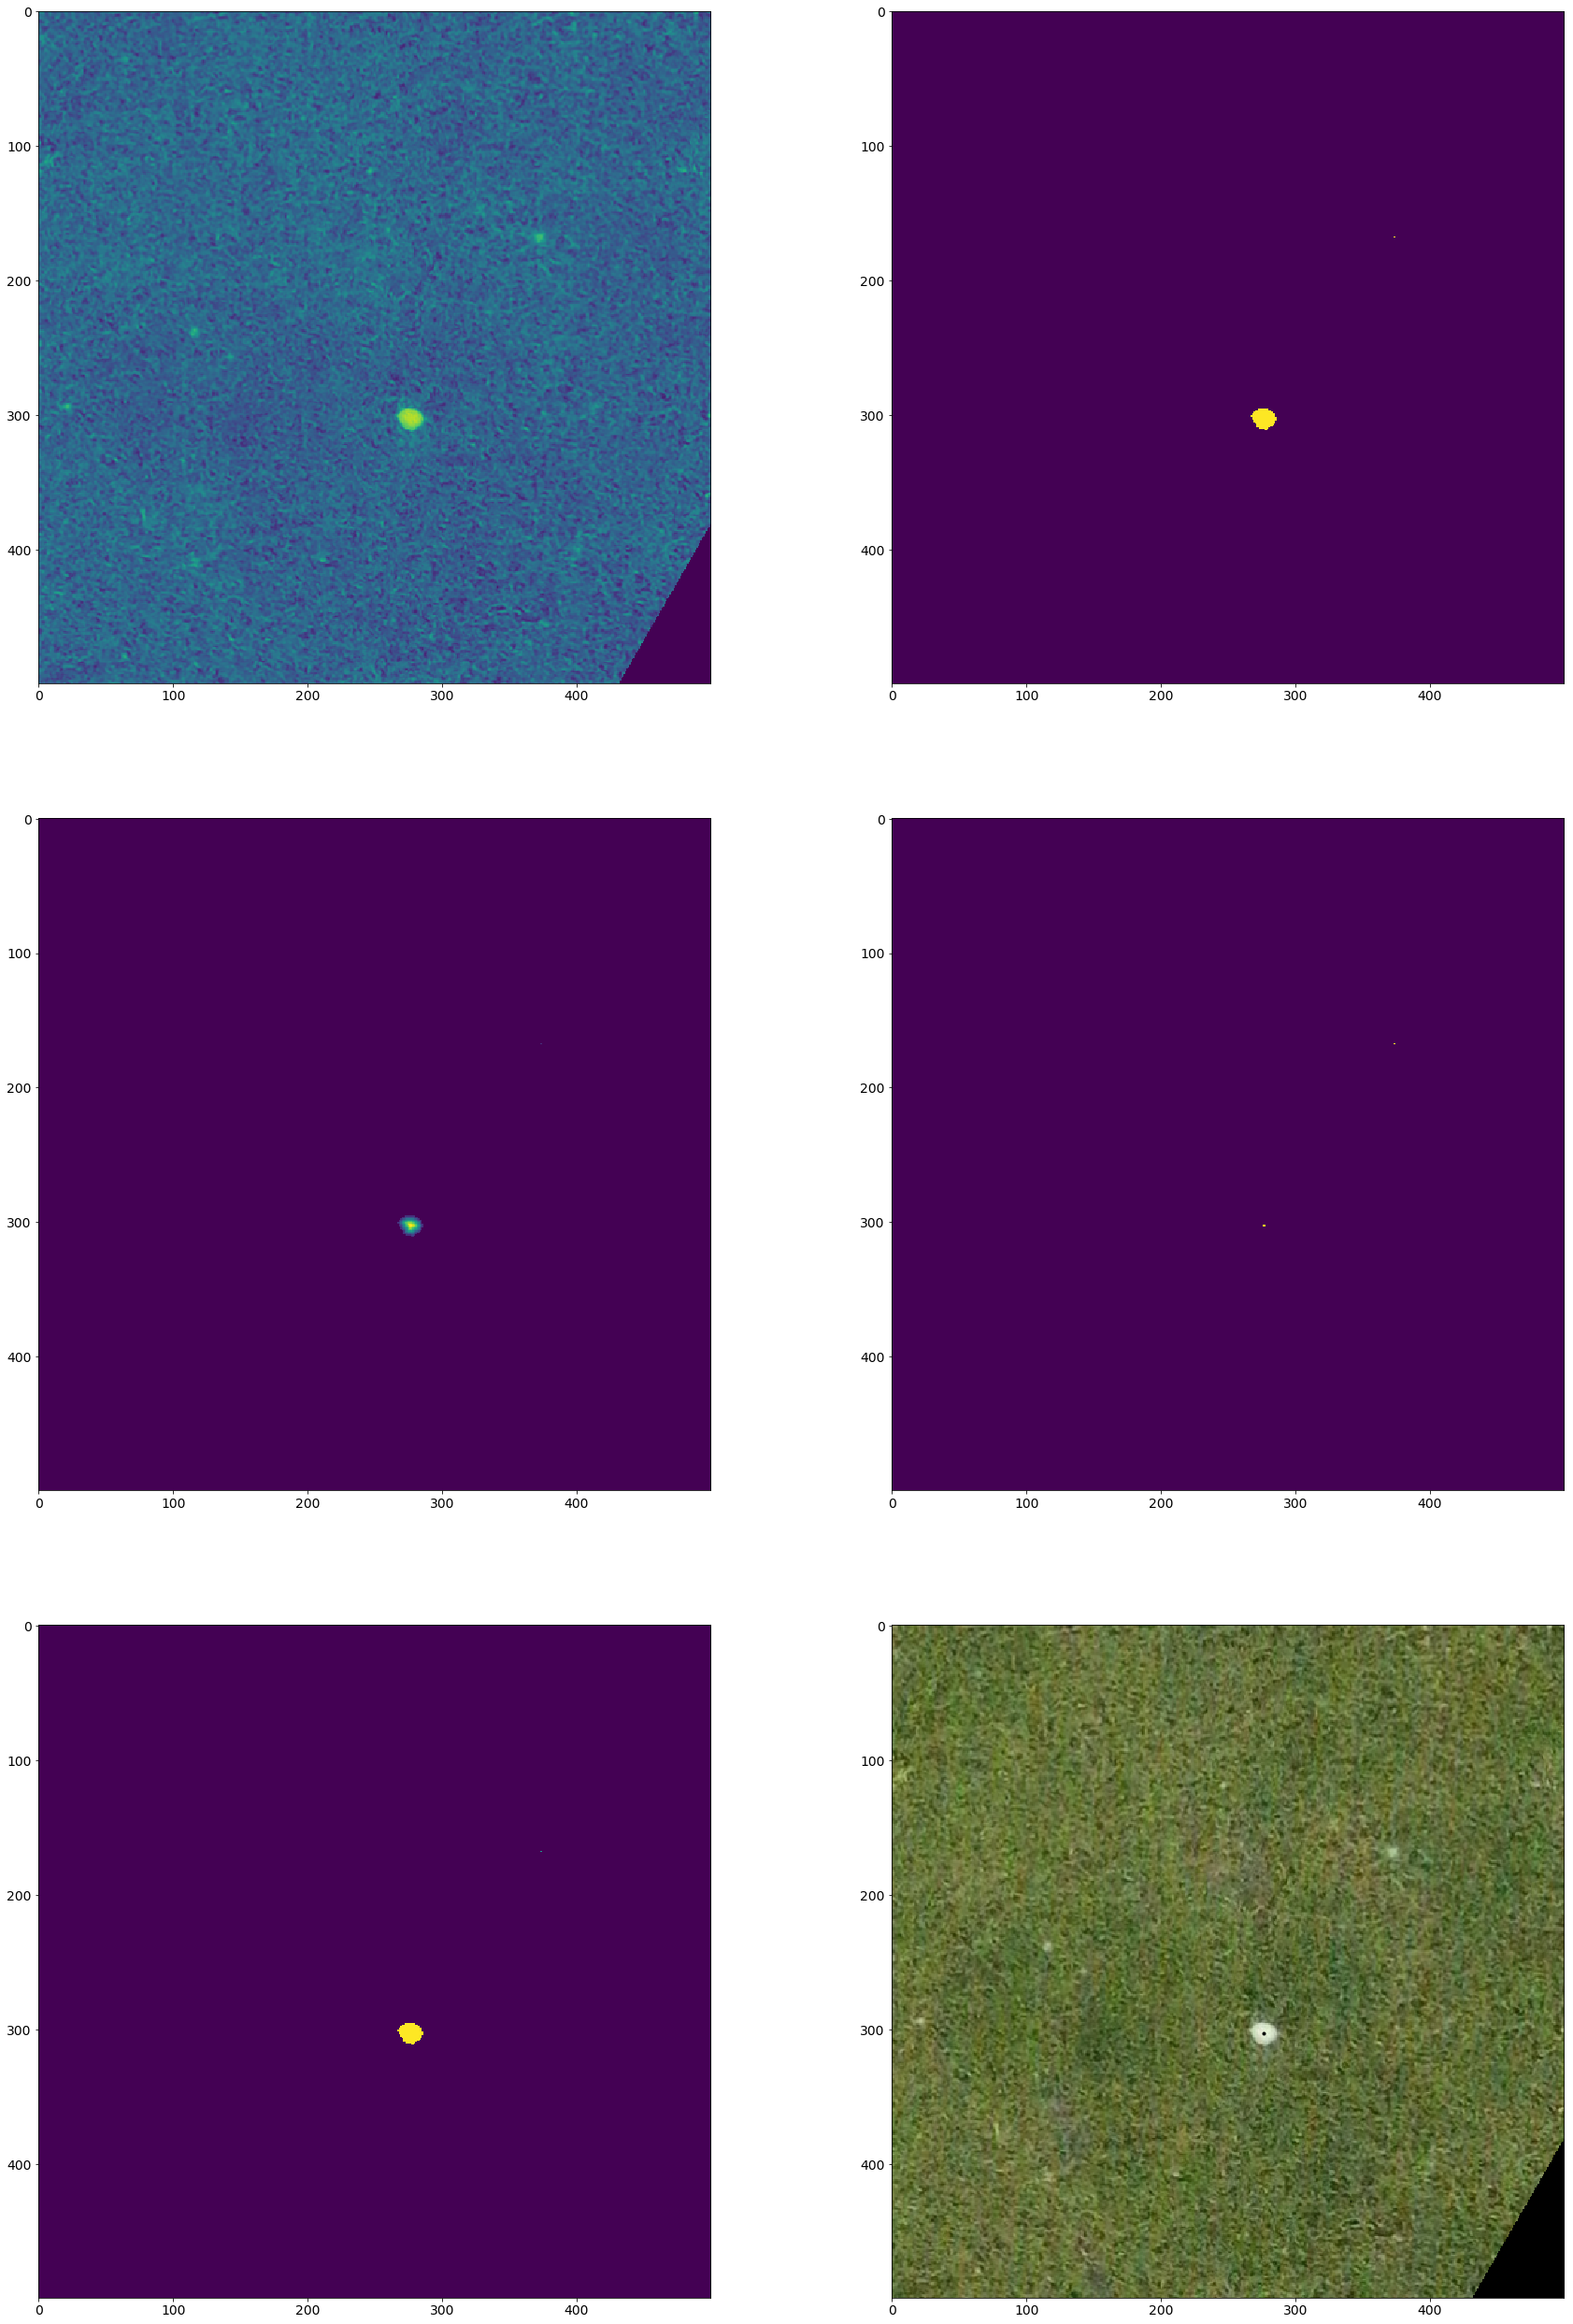

In [15]:
#full plot
fig, axes = plt.subplots(nrows=3, ncols=2, facecolor='white',figsize=[30, 45])

im = axes[0,0].imshow(l_data, vmin=0, vmax=1)
im = axes[0,1].imshow(l_mask, vmin=0, vmax=1)
im = axes[1,0].imshow(l_mask_dist)
im = axes[1,1].imshow(localMax)
im = axes[2,0].imshow(labels)
im = axes[2,1].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
axes[2,1].plot(hail_centroid_x, hail_centroid_y, 'k.')

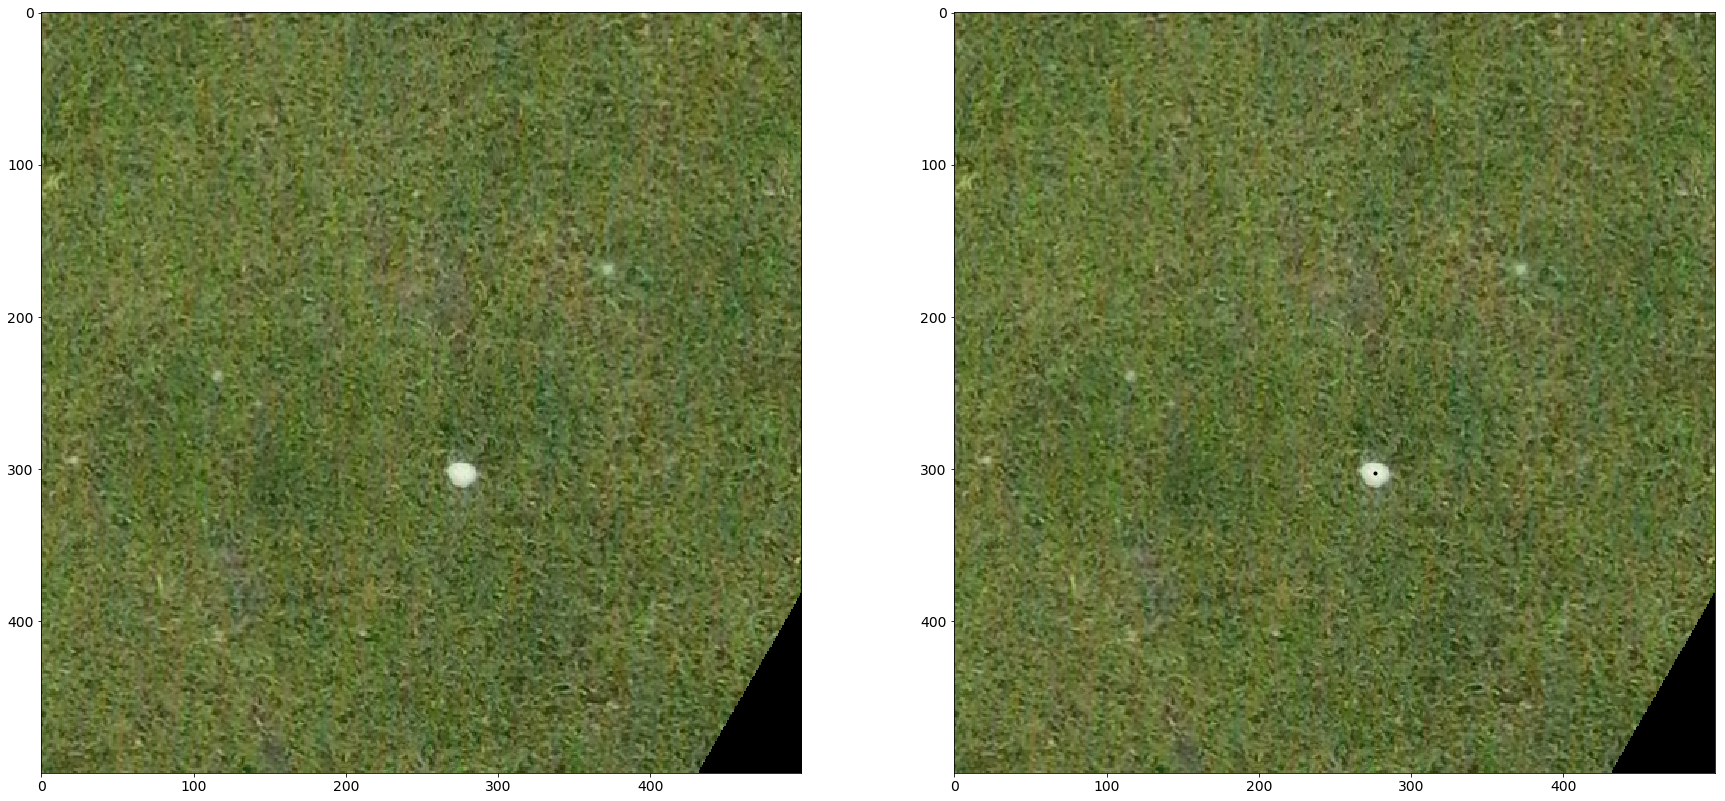

In [16]:
#simple plot
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor='white',figsize=[30, 15])
im = axes[0].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
im = axes[1].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
axes[1].plot(hail_centroid_x, hail_centroid_y, 'k.')

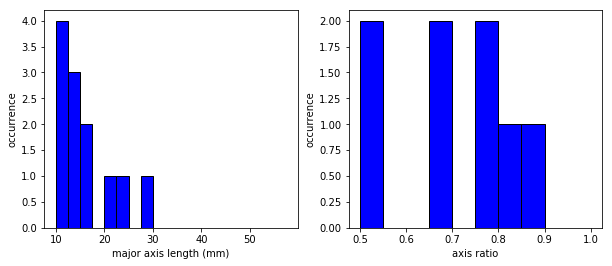

In [34]:
#plot distributions
def plot_stats(hail_maj, hail_min):
    pixel_scaling = 1.5 #mm/pixel
    
    #apply scaling
    hail_maj = hail_maj*pixel_scaling
    hail_min = hail_min*pixel_scaling
    
    # matplotlib histogram
    fig = plt.figure(facecolor='white',figsize=[10, 4])

    plt.subplot(1, 2, 1)
    plt.hist(hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(10,60,2.5))
    plt.xlabel('major axis length (mm)')
    plt.ylabel('occurrence')

    plt.subplot(1, 2, 2)
    plt.hist(hail_min/hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(0.5,1.05,0.05))
    plt.xlabel('axis ratio')
    plt.ylabel('occurrence')


hail_major_array = np.array(hail_major)
hail_minor_array = np.array(hail_minor)

plot_stats(hail_major_array, hail_minor_array)